In [39]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils import graph_tools, qaoaCUDAQ as q, graph_tools
import networkx as nx
import time

cudaq.set_target("nvidia")

In [40]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz
from qiskit_optimization.translators import to_ising
from qiskit.result import marginal_distribution

In [41]:
def po_normalize(B, P, ret, cov):
    P_b = P / B
    ret_b = ret * P_b
    cov_b = np.diag(P_b) @ cov @ np.diag(P_b)
    
    n_max = np.int32(np.floor(np.log2(B/P))) + 1
    n_qs = np.cumsum(n_max)
    n_qs = np.insert(n_qs, 0, 0)
    n_qubit = n_qs[-1]
    C = np.zeros((len(P), n_qubit))
    for i in range(len(P)):
         for j in range(n_max[i]):
              C[i, n_qs[i] + j] = 2**j

    P_bb = C.T @ P_b
    ret_bb = C.T @ ret_b
    cov_bb = C.T @ cov_b @ C
    return P_bb, ret_bb, cov_bb, int(n_qubit)

def ret_cov_to_QUBO(ret: np.ndarray, cov: np.ndarray, P: np.ndarray, lamb: float, q:float) -> np.ndarray:
    di = np.diag(ret + lamb * (P*P + 2*P))
    mat = 2 * lamb * np.outer(P, P) + q * cov
    return di - mat

def qubo_to_ising(qubo: np.ndarray, lamb: float) -> cudaq.SpinOperator:
    spin_op = lamb
    for i in range(qubo.shape[0]):
        for j in range(qubo.shape[1]):
                if i != j:
                    spin_op += qubo[i, j] * ((spin.i(i) - spin.z(i)) / 2 * (spin.i(j) - spin.z(j)) / 2)
                else:
                    spin_op += qubo[i, j] * (spin.i(i) - spin.z(i)) / 2
    return spin_op

# HAMILTONIAN BY CUDAQ

In [44]:
B = 100
ret = np.array([0.1, 0.5, 0.2])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 1 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)


[[0.98234742 0.66687544 1.68907488]
 [0.66687544 1.10890076 1.0726221 ]
 [1.68907488 1.0726221  1.78303537]]
n_qubit: 3


In [34]:
a = [True, False, True]
print(sum(a))

b = [[True, False, True], [True, False, False]]
b = sorted(b, key=lambda x: sum(x), reverse=False)
print(b)

2
[[True, False, False], [True, False, True]]


In [35]:
print("Hamiltonian:", H)
HH = H.get_raw_data()
print(HH[0])
print(HH[1])


idxs = [[j - len(HH[0][i])//2 for j in range(len(HH[0][i])) if HH[0][i][j]] for i in range(len(HH[0]))]
print(idxs)

HH = [(idxs[i], HH[1][i], sum(HH[0][i])) for i in range(len(HH[0]))]
HH = sorted(HH, key=lambda x: (x[2], x[0]), reverse=False)
print(HH)

Hamiltonian: [1+0j] IZZ
[1+0j] ZIZ
[-1.45+0j] ZII
[-1.4+0j] IIZ
[2.1+0j] III
[1+0j] ZZI
[-1.25+0j] IZI

[[False, False, False, False, True, True], [False, False, False, True, False, True], [False, False, False, True, False, False], [False, False, False, False, False, True], [False, False, False, False, False, False], [False, False, False, True, True, False], [False, False, False, False, True, False]]
[(1+0j), (1+0j), (-1.45+0j), (-1.4+0j), (2.1+0j), (1+0j), (-1.25+0j)]
[[1, 2], [0, 2], [0], [2], [], [0, 1], [1]]
[([], (2.1+0j), 0), ([0], (-1.45+0j), 1), ([1], (-1.25+0j), 1), ([2], (-1.4+0j), 1), ([0, 1], (1+0j), 2), ([0, 2], (1+0j), 2), ([1, 2], (1+0j), 2)]


# HAMILTONIAN by QISKIT

In [64]:
ret[0][2] = 0
ret[2][0] = 0

portfolio_qis = PortfolioOptimization(
    expected_returns=ret.astype(np.float32),
    covariances=cov.astype(np.float32),
    risk_factor=q,
    budget=2,
    bounds=[(0, 2), (0, 2), (0, 2)]
)
qp = portfolio_qis.to_quadratic_program()
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
op, offset = to_ising(qubo)

TypeError: 'numpy.float64' object does not support item assignment

In [53]:
print(qubo.to_ising())
print(H)
print(op.num_qubits)

(SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[-2.55000001+0.j, -2.55000001+0.j, -2.35000001+0.j, -2.35000001+0.j,
 -2.50000001+0.j, -2.50000001+0.j,  1.3       +0.j,  1.3       +0.j,
  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,
  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,
  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,  1.3       +0.j,
  1.3       +0.j]), np.float64(5.700000017881393))
[1+0j] IZZ
[1+0j] ZIZ
[-1.45+0j] ZII
[-1.4+0j] IIZ
[2.1+0j] III
[1+0j] ZZI
[-1.25+0j] IZI

6


In [62]:
!pip list

Package                  Version
------------------------ -----------
astpretty                3.0.0
asttokens                3.0.0
beautifulsoup4           4.13.4
certifi                  2025.1.31
cffi                     1.17.1
charset-normalizer       3.4.1
comm                     0.2.2
contourpy                1.3.1
cuda-quantum-cu12        0.9.1
cudaq                    0.9.1
cudensitymat-cu12        0.0.5
cupy-cuda12x             13.4.0
cuquantum-python-cu12    24.11.0
curl_cffi                0.11.1
custatevec-cu12          1.7.0
cutensor-cu12            2.0.2
cutensornet-cu12         2.6.0
cycler                   0.12.1
debugpy                  1.8.12
decorator                5.2.1
dill                     0.3.9
docplex                  2.29.241
exceptiongroup           1.2.2
executing                2.1.0
fastdtw                  0.3.4
fastrlock                0.8.3
fonttools                4.56.0
frozendict               2.4.6
idna                     3.10
importlib_metada

In [54]:
qaoa_ansatz = QAOAAnsatz(op, reps=2)
decomposed = qaoa_ansatz.decompose(reps=2)
decomposed.draw(output='text')

┌─────────┐┌────────────────────────────┐                           »
q_0: ┤ U2(0,π) ├┤ Rz(-5.10000001639128*γ[0]) ├─■─────────────────────────»
     ├─────────┤├────────────────────────────┤ │ZZ(2.6000000089407*γ[0]) »
q_1: ┤ U2(0,π) ├┤ Rz(-5.10000001639128*γ[0]) ├─■─────────────────────────»
     ├─────────┤├────────────────────────────┤                           »
q_2: ┤ U2(0,π) ├┤ Rz(-4.70000001788139*γ[0]) ├───────────────────────────»
     ├─────────┤├────────────────────────────┤                           »
q_3: ┤ U2(0,π) ├┤ Rz(-4.70000001788139*γ[0]) ├───────────────────────────»
     ├─────────┤├────────────────────────────┤                           »
q_4: ┤ U2(0,π) ├┤ Rz(-5.00000001490116*γ[0]) ├───────────────────────────»
     ├─────────┤├────────────────────────────┤                           »
q_5: ┤ U2(0,π) ├┤ Rz(-5.00000001490116*γ[0]) ├───────────────────────────»
     └─────────┘└────────────────────────────┘                           »
«                                                           »
«q_0: ─■────────────────────────────────────────────────────»
«      │                                                    »
«q_1: ─┼──────────────────────────■─────────────────────────»
«      │ZZ(2.6000000089407*γ[0])  │ZZ(2.6000000089407*γ[0]) »
«q_2: ─■──────────────────────────■─────────────────────────»
«                                                           »
«q_3: ──────────────────────────────────────────────────────»
«                                                           »
«q_4: ──────────────────────────────────────────────────────»
«                                                           »
«q_5: ──────────────────────────────────────────────────────»
«                                                           »
«                                                           »
«q_0: ─■────────────────────────────────────────────────────»
«      │                                                    »
«q_1: ─┼──────────────────────────■─────────────────────────»
«      │                          │                         »
«q_2: ─┼──────────────────────────┼─────────────────────────»
«      │ZZ(2.6000000089407*γ[0])  │ZZ(2.6000000089407*γ[0]) »
«q_3: ─■──────────────────────────■─────────────────────────»
«                                                           »
«q_4: ──────────────────────────────────────────────────────»
«                                                           »
«q_5: ──────────────────────────────────────────────────────»
«                                                           »
«                                                           »
«q_0: ─■────────────────────────────────────────────────────»
«      │                                                    »
«q_1: ─┼────────────────────────────────────────────────────»
«      │                                                    »
«q_2: ─┼──────────────────────────■─────────────────────────»
«      │                          │ZZ(2.6000000089407*γ[0]) »
«q_3: ─┼──────────────────────────■─────────────────────────»
«      │ZZ(2.6000000089407*γ[0])                            »
«q_4: ─■────────────────────────────────────────────────────»
«                                                           »
«q_5: ──────────────────────────────────────────────────────»
«                                                           »
«                                                           »
«q_0: ────────────────────────────■─────────────────────────»
«                                 │                         »
«q_1: ─■──────────────────────────┼─────────────────────────»
«      │                          │                         »
«q_2: ─┼──────────────────────────┼─────────────────────────»
«      │                          │                         »
«q_3: ─┼──────────────────────────┼─────────────────────────»
«      │ZZ(2.6000000089407*γ[0])  │                         »
«q_4: ─■──────────────────────────┼───────────────────

In [55]:
qaoa = QAOA(
    optimizer=COBYLA(maxiter=1000),
    reps=2,
    sampler=Sampler()
)

meo = MinimumEigenOptimizer(qaoa)

result = meo.solve(qubo)

/tmp/ipykernel_15364/1284845384.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler()


In [56]:
qaoa_result = qaoa.compute_minimum_eigenvalue(operator=op)
print("Optimized parameters:", qaoa_result.optimal_point)

Optimized parameters: [-1.18909691  0.304961    3.40017017 -1.35360602]


In [57]:
counts = qaoa_result.eigenstate
counts = np.array(list(counts.values()))

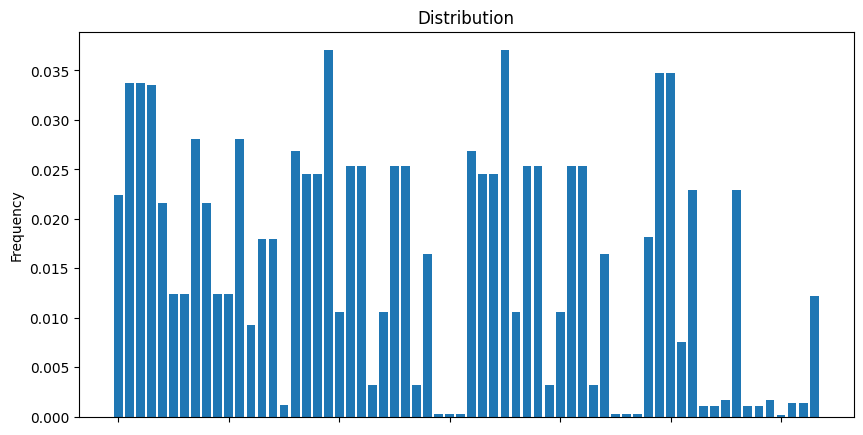

In [58]:
plt.figure(figsize=(10, 5))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**op.num_qubits), counts)
# plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Distribution')
# plt.gca().set_xticklabels([])
plt.xticks(rotation=90)
plt.xticks(visible=False)
plt.show()

In [161]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [162]:
print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

     ╭───╮                                                               ╭───╮»
q0 : ┤ h ├──●───────────────●────────────────────────────────────────────┤ x ├»
     ├───┤╭─┴─╮╭─────────╮╭─┴─╮                                          ╰─┬─╯»
q1 : ┤ h ├┤ x ├┤ rz(0.2) ├┤ x ├──●───────────────●─────────────────────────┼──»
     ├───┤╰───╯╰─────────╯╰───╯╭─┴─╮╭─────────╮╭─┴─╮                       │  »
q2 : ┤ h ├─────────────────────┤ x ├┤ rz(0.2) ├┤ x ├──●───────────────●────┼──»
     ├───┤                     ╰───╯╰─────────╯╰───╯╭─┴─╮╭─────────╮╭─┴─╮  │  »
q3 : ┤ h ├──────────────────────────────────────────┤ x ├┤ rz(0.2) ├┤ x ├──●──»
     ╰───╯                                          ╰───╯╰─────────╯╰───╯     »

################################################################################

╭─────────╮╭───╮╭─────────╮                                               »
┤ rz(0.2) ├┤ x ├┤ rx(0.2) ├──●───────────────●────────────────────────────»
╰─────────╯╰─┬─╯├─────────┤╭─┴─╮╭─────────╮╭─

In [27]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], sorted_raw_ham: List[tuple]):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)

    for i in range(layer_count):
        for idxs, coeff, l in sorted_raw_ham:
            if l == 1:
                rz(2 * coeff * thetas[i], qreg[idxs[0]])
            elif l == 2:
                x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
                rz(2 * coeff * thetas[i], qreg[idxs[1]])
                x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        for i in range(qubit_count):
            rx(2.0 * thetas[layer_count + i], qreg[i])

In [21]:

print(HH)

[([], (128+0j), 0), ([0], (-32.25+0j), 1), ([1], (-59.5+0j), 1), ([2], (-31.75+0j), 1), ([3], (-58.5+0j), 1), ([4], (-32+0j), 1), ([5], (-59+0j), 1), ([0, 1], (10+0j), 2), ([0, 2], (5+0j), 2), ([0, 3], (10+0j), 2), ([0, 4], (5+0j), 2), ([0, 5], (10+0j), 2), ([1, 2], (10+0j), 2), ([1, 3], (20+0j), 2), ([1, 4], (10+0j), 2), ([1, 5], (20+0j), 2), ([2, 3], (10+0j), 2), ([2, 4], (5+0j), 2), ([2, 5], (10+0j), 2), ([3, 4], (10+0j), 2), ([3, 5], (20+0j), 2), ([4, 5], (10+0j), 2)]


In [28]:
print(cudaq.draw(kernel_qaoa_ham, 3, 2, [0.1]*4, HH)) 

CompilerError: 1833814492.py:2: [91merror: [0m[1m[91merror: [0m[1mtuple is not a supported type.[0m

Offending code:
  File "<frozen runpy>", line 198, in _run_module_as_main

	 (offending source -> List[tuple])[0m

In [163]:
idx = 3
layer_count = 2

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [-0.22386886988356933, -0.2786307215049424, 0.377768866929831, -0.042288292450908094]


In [164]:
expectations = []

def cost_func(parameters):
    return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [165]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = 27.000128361090788
optimal_parameters = [-0.2959937173926062, -0.08920618901052137, 0.2853222326040036, 0.028334234284429827]
Time taken =  0.45058178901672363


In [166]:
shots_count = int(1e7)
print(f"Sampling {shots_count} times...")
result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)



Sampling 10000000 times...
Finding the best solution...
001 1668659 0.1668659
110 1665468 0.1665468


In [167]:
assert False

AssertionError: 

In [168]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

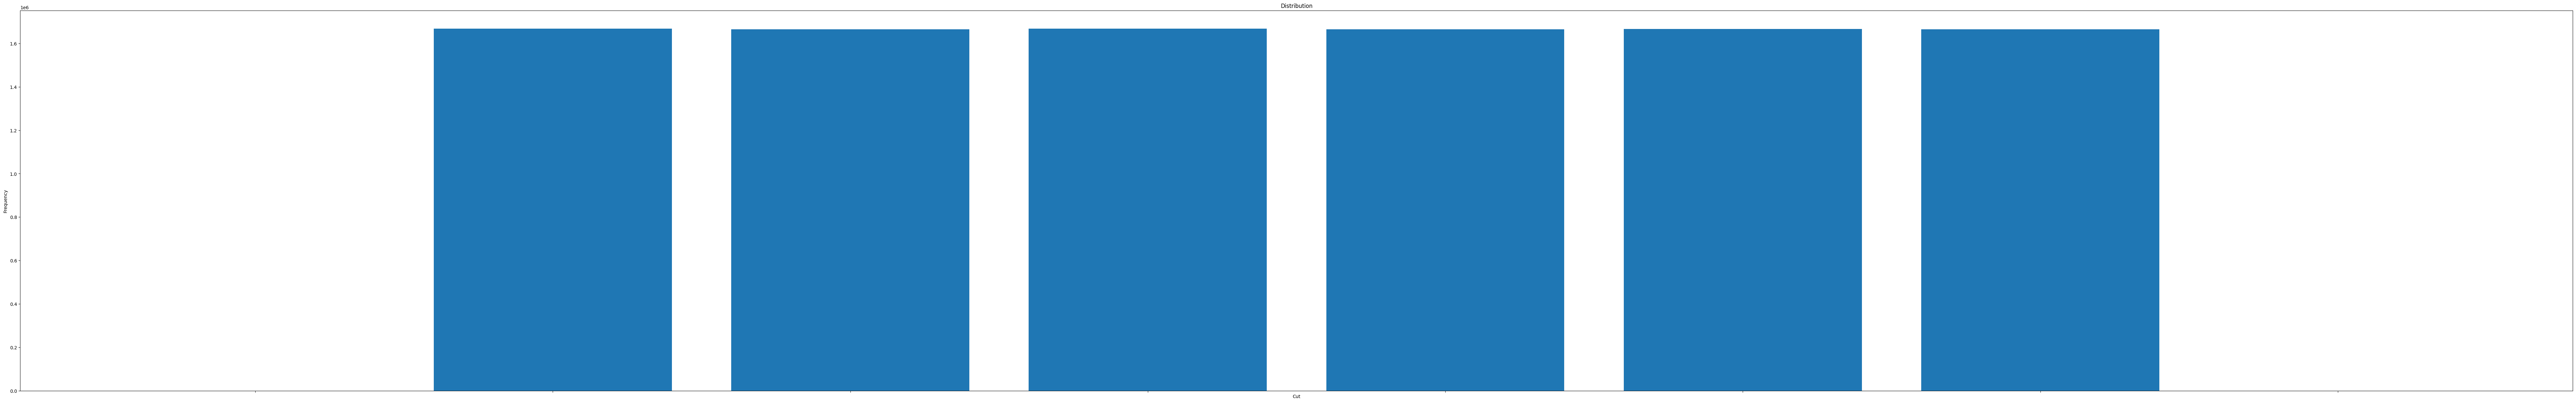

In [169]:
plt.figure(figsize=(100, 15))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Loading expectations from COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Loading expectations from GradientDescent


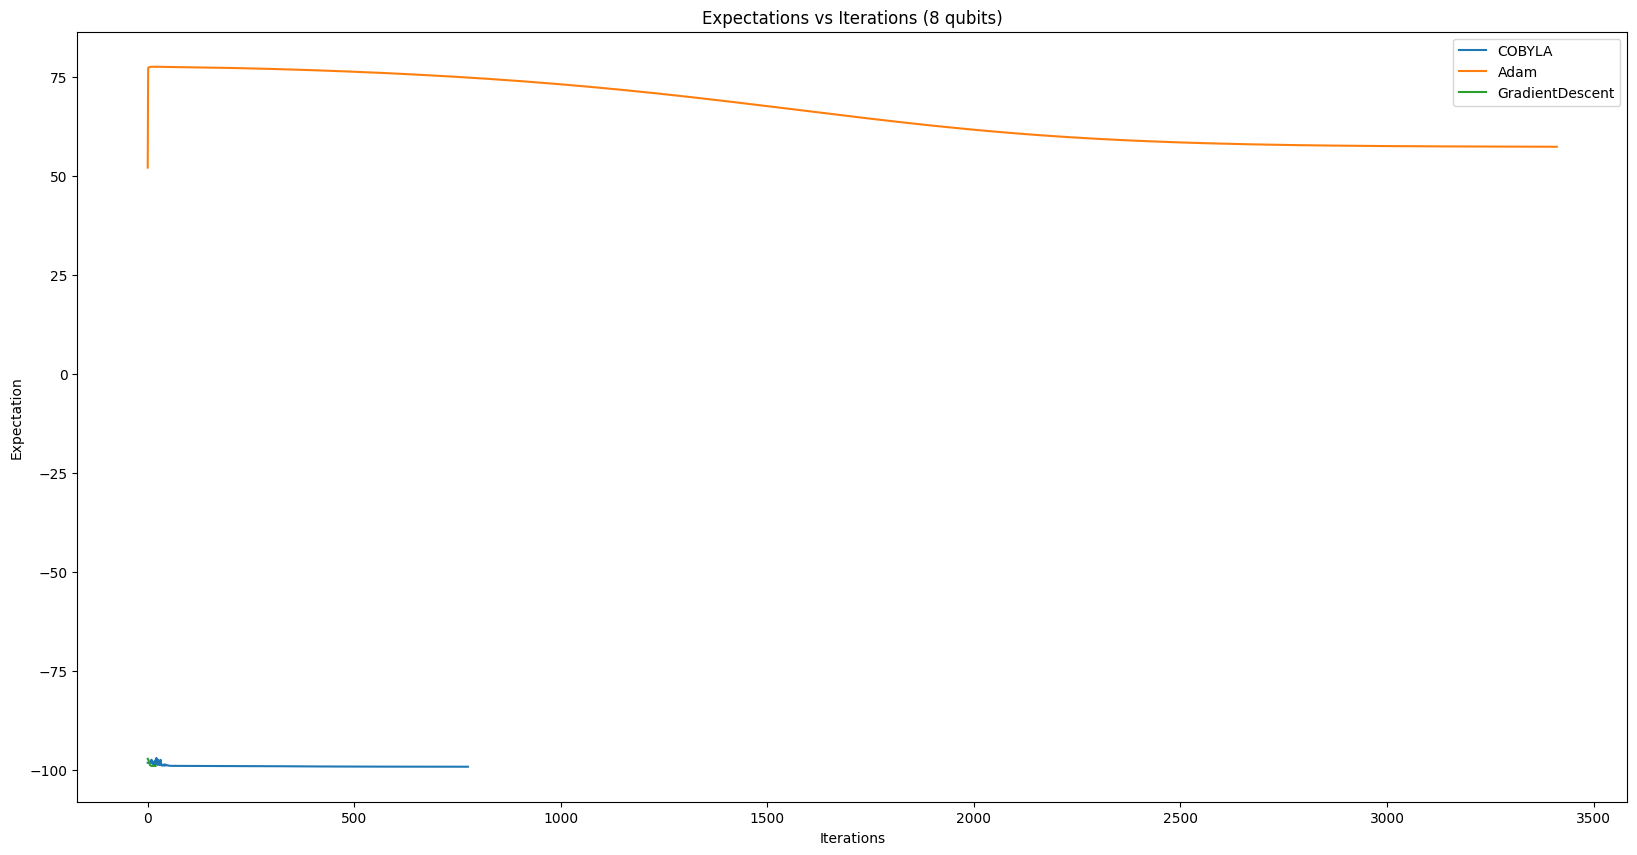

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()